# Simulating hard spheres with Monte Carlo

Notebook written by [Manon Michel](manon.michel@uca.fr)

The goal here is to sample hard spheres systems. 

Hard spheres interact through an exclusion force, meaning that they cannot overlap. For a given diameter $\sigma>0$, the stationary probability distribution for of $N$ spheres in dimension $d$ in a square box of size $L$ with periodic boundaries has density with respect to the Lebesgue measure given by  $$\pi(x) = \prod_{i=1}^n\left( \prod_{k=1}^d\mathbb{1}(x_{i,k} >0)\mathbb{1}(x_{i,k} - L <0)\prod_{j<i} \mathbb{1}(||x_i-x_j||_2 - \sigma > 0) \right) \, .$$
Here $x \in \mathbb{R}^{d\times N}$ is a configuration of $N$ spheres at coordinates $x_i \in \mathbb{R}^d$ with $i \in \{1,\ldots,N\}$.

In [237]:
import numpy as np
import random, math
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 8

## 1) Two schemes for rejection sampling

We set $d=2$, $N=4$, $\sigma=1$ and $L=16$. 

> 1. Use the following code to generate 10000 configurations with both reject-sampling routines.
> 2. Plot the histograms of the interdistance between spheres (one plot) and of the x-coordinate and y-coordinate of the sphere positions (another plot) and compare both algorithms.
> 3. Plot the cumulative histograms of the interdistance between spheres (one plot) and of the x-coordinate and y-coordinate of the sphere positions (another plot) and compare both algorithms.

In [238]:
class periodic_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        x_i_new = self.L * np.random.uniform(size=2) 
        return x_i_new
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    x = []
                    break
                x += [x_i_new]
        return x    

In [239]:
reject_sampling_1 = None
reject_sampling_2 = None
sampling_model = periodic_hard_sphere()

def config(N=4, d=2, sigma=1.0, L = 16):
    global reject_sampling_1, reject_sampling_2, sampling_model
    sampling_model = periodic_hard_sphere(N=N, d=d, sigma=1.0, L=L)
    reject_sampling_1 = []
    reject_sampling_2 = []

    for i in range(10000):
        reject_sampling_1.append(sampling_model.rejection_sampling_1())
        reject_sampling_2.append(sampling_model.rejection_sampling_2())

config()
print(reject_sampling_1[0])
print(reject_sampling_2[0])

[array([12.12144386,  7.60405053]), array([10.9785907 , 14.32070575]), array([ 8.96039363, 14.55221256]), array([9.89195251, 7.06124997])]
[array([9.77883592, 1.3558995 ]), array([1.31208981, 8.60329835]), array([9.71720962, 6.86209443]), array([8.20199657, 6.77177923])]


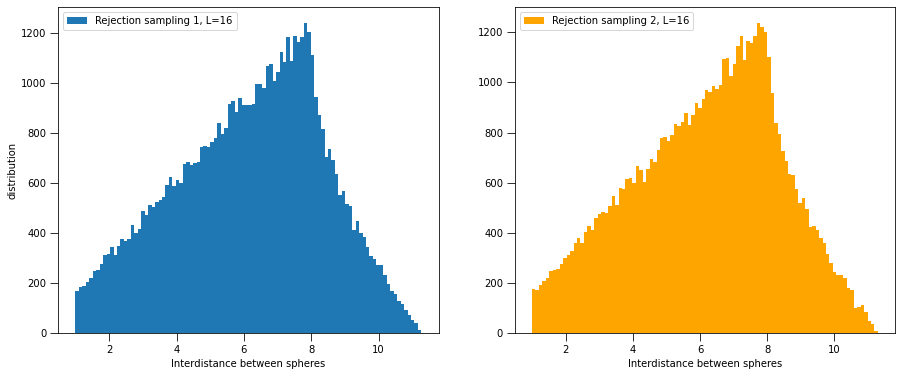

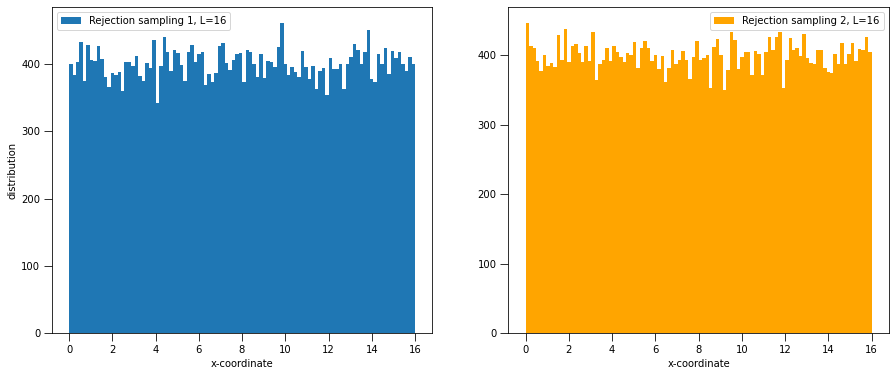

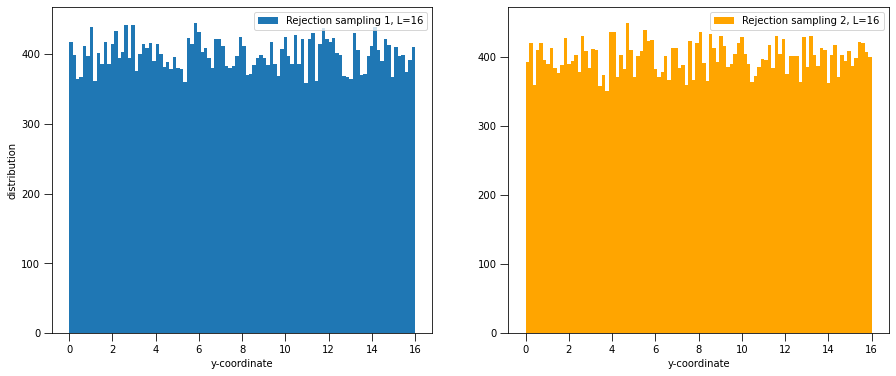

In [240]:
interdistance_1 = None
interdistance_2 = None
x_1 = None
y_1 = None
x_2 = None
y_2 = None

def plot_result_non_cumu(name1="Rejection sampling 1", name2="Rejection sampling 2"):
    global interdistance_1, interdistance_2, x_1, y_1, x_2, y_2
    # Plot the histograms of the interdistance between spheres (one plot) 
    plt.figure(figsize=(15,6))
    N = len(reject_sampling_1[0])
    interdistance_1 = []
    interdistance_2 = []
    for i in range(10000):
        for j in range(N):
            for k in range(j+1,N):
                try:
                    interdistance_1.append(sampling_model.get_periodic_distance(reject_sampling_1[i][j],reject_sampling_1[i][k]))
                    interdistance_2.append(sampling_model.get_periodic_distance(reject_sampling_2[i][j],reject_sampling_2[i][k]))
                except:                
                    interdistance_1.append(np.linalg.norm(reject_sampling_1[i][j] - reject_sampling_1[i][k]))
                    interdistance_2.append(np.linalg.norm(reject_sampling_2[i][j] - reject_sampling_2[i][k]))

    plt.subplot(1,2,1)
    plt.hist(interdistance_1, bins=100, label=name1)
    plt.ylabel('distribution')
    plt.xlabel('Interdistance between spheres')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(interdistance_2, bins=100, color='orange', label=name2)
    plt.xlabel('Interdistance between spheres')
    plt.legend()


    # Plot the x-coordinate of the sphere positions (another plot) and compare both algorithms
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []
    for i in range(10000):
        for j in range(N):
            x_1.append(reject_sampling_1[i][j][0])
            y_1.append(reject_sampling_1[i][j][1])
            x_2.append(reject_sampling_2[i][j][0])
            y_2.append(reject_sampling_2[i][j][1])

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.hist(x_1, bins=100, label=name1)
    plt.xlabel('x-coordinate')
    plt.ylabel('distribution')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(x_2, bins=100, color='orange', label=name2)
    plt.xlabel('x-coordinate')
    plt.legend()


    # y-coordinate of the sphere positions (another plot) and compare both algorithms
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.hist(y_1, bins=100, label=name1)
    plt.xlabel('y-coordinate')
    plt.ylabel('distribution')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(y_2, bins=100, color='orange', label=name2)
    plt.xlabel('y-coordinate')
    plt.legend()
    plt.show()

plot_result_non_cumu(name1="Rejection sampling 1, L=16", name2="Rejection sampling 2, L=16")

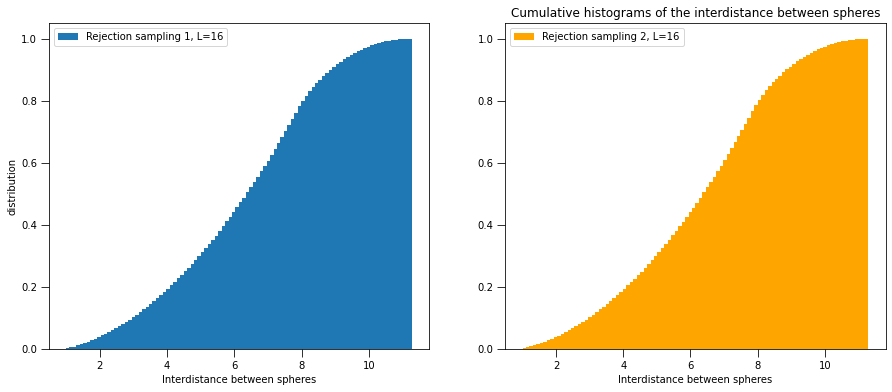

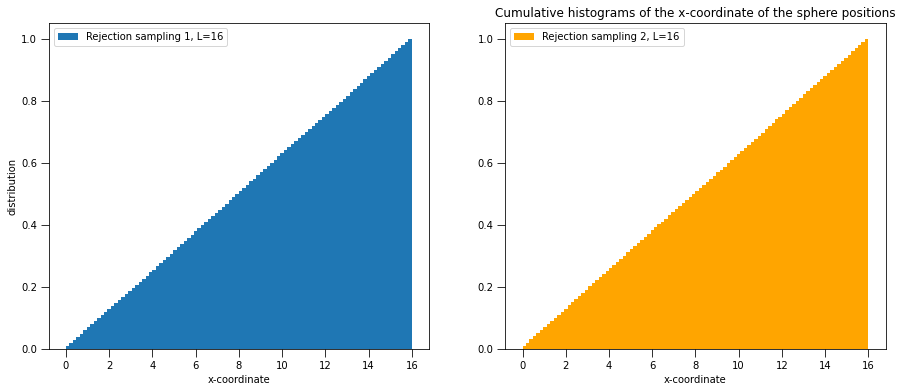

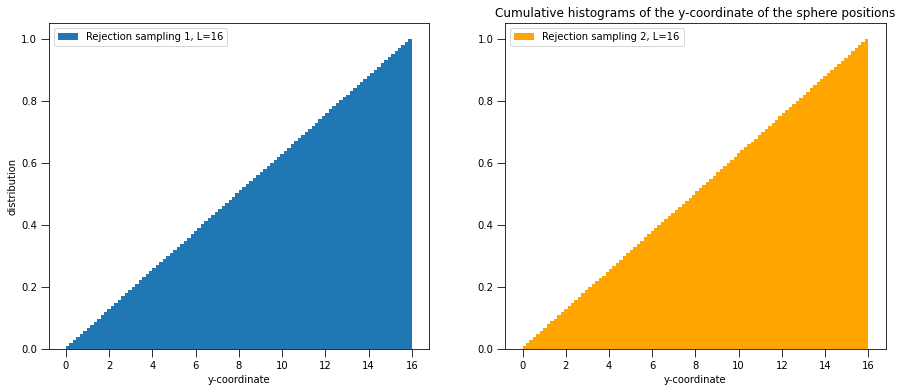

In [241]:
def plot_result_cumu(name1="Rejection sampling 1", name2="Rejection sampling 2"):
    # Plot the cumulative histograms of the interdistance between spheres (one plot)
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.hist(interdistance_1, bins=100, density=True, cumulative=True, label=name1)
    plt.xlabel('Interdistance between spheres')
    plt.ylabel('distribution')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(interdistance_2, bins=100, color='orange', density=True, cumulative=True, label=name2)
    plt.xlabel('Interdistance between spheres')
    plt.legend()

    plt.title('Cumulative histograms of the interdistance between spheres')
    plt.show()


    plt.figure(figsize=(15,6))
    # Plot the cumulative histograms of the x-coordinate
    plt.subplot(1,2,1)
    plt.hist(x_1, bins=100, density=True, cumulative=True, label=name1)
    plt.xlabel('x-coordinate')
    plt.ylabel('distribution')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(x_2, bins=100, density=True, color='orange', cumulative=True, label=name2)
    plt.xlabel('x-coordinate')
    plt.legend()

    plt.title('Cumulative histograms of the x-coordinate of the sphere positions')
    plt.show()

    plt.figure(figsize=(15,6))
    # Plot the cumulative histograms of the y-coordinate
    plt.subplot(1,2,1)
    plt.hist(y_1, bins=100, density=True, cumulative=True, label=name1)
    plt.xlabel('y-coordinate')
    plt.ylabel('distribution')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(y_2, bins=100, density=True, color='orange', cumulative=True, label=name2)
    plt.xlabel('y-coordinate')
    plt.legend()

    plt.title('Cumulative histograms of the y-coordinate of the sphere positions')
    plt.show()

plot_result_cumu(name1="Rejection sampling 1, L=16", name2="Rejection sampling 2, L=16")

> Comment your results:

The distribution of interdistance between spheres is quite similar for both algorithms. This suggests that the spatial configurations of the spheres generated by the two methods are comparable. The absence of distinct peaks or troughs specific to one method indicates a certain consistency in how the spheres are arranged relative to each other.

The histograms for the X and Y coordinates also show a notable similarity between the two methods. The distributions appear uniform and consistent, indicating that both methods distribute the spheres uniformly throughout the box. A uniform distribution is expected in a system where spheres are randomly arranged, subject to the constraint of non-overlapping.

The cumulative histograms for both methods overlap almost perfectly, reinforcing the idea that the distributions of inter-sphere distances and X and Y coordinates are very similar for both methods. This similarity in the cumulative histograms suggests that the methods are in good agreement in terms of the overall distribution of values.

>  4. Do you have agreement between the two methods? 

Based on the last comments, we can say that the two methods are in good agreement. 
They both generate spatial configurations of spheres that are consistent with the constraints of the system and the distribution of values is similar for both methods.

> 5. Is the obtained histograms consistent with the expression of $\pi$?


The histograms of the X and Y coordinates we observed appear uniform, aligning with the expression of $\pi$. In fact, the distribution $\pi$ suggests that each sphere should be uniformly distributed within the box, subject to the constraint of non-overlapping.


The expression involving $\pi$ also implies that no pair of spheres should overlap (inter-sphere distance greater than $\sigma$). Therefore, the histograms of inter-sphere distances should exhibit an absence of values below the $\sigma = 1$ threshold, what is the case. So, it confirms consistency with $\pi$.


> 6. Redo the experience with $L=3$. What happens?

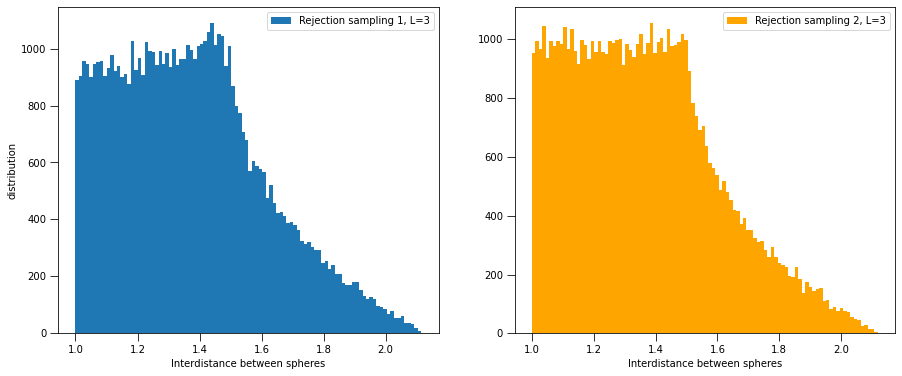

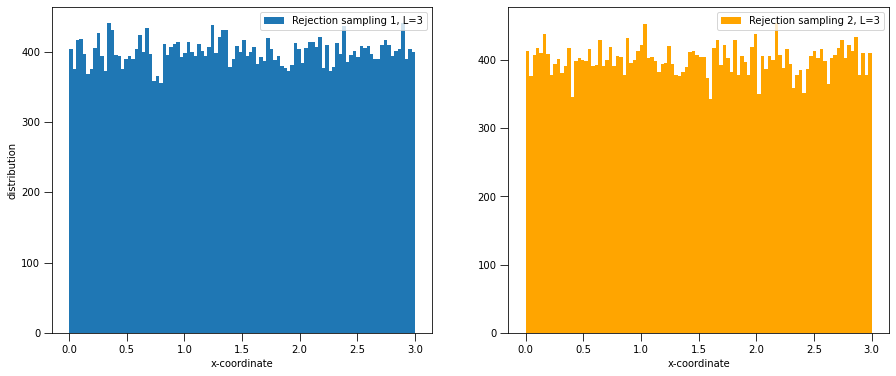

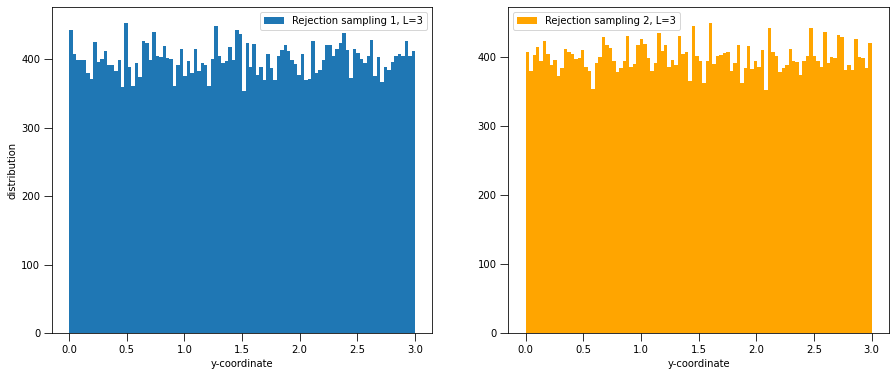

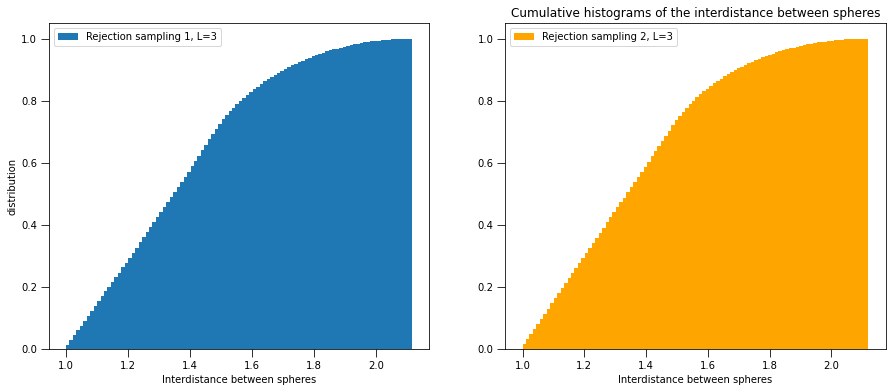

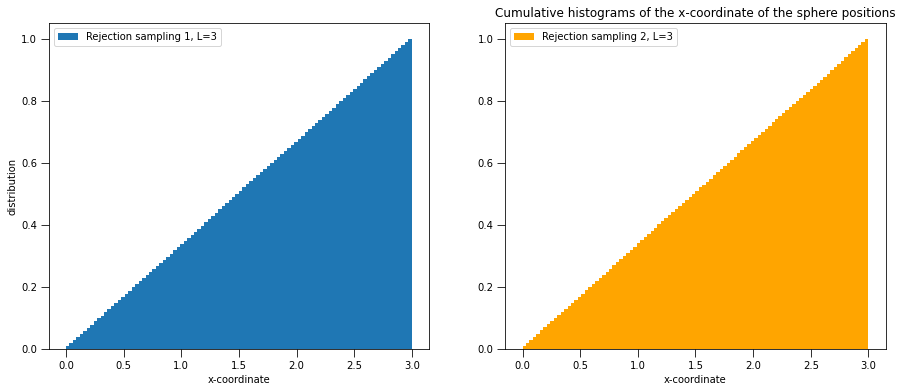

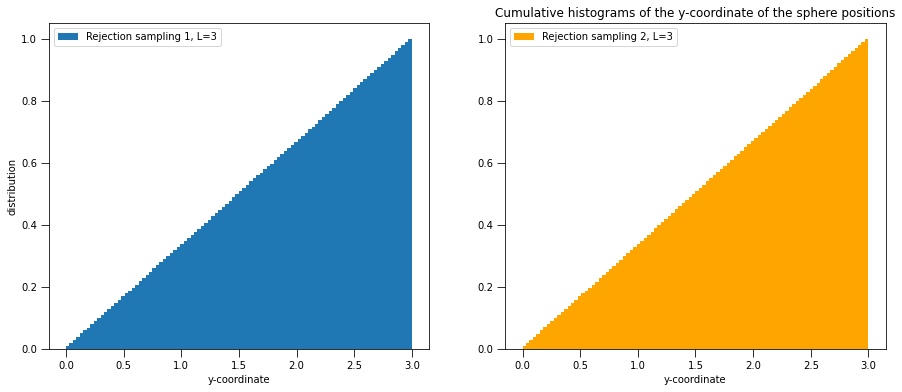

In [242]:
config(L=3)
plot_result_non_cumu(name1="Rejection sampling 1, L=3", name2="Rejection sampling 2, L=3")
plot_result_cumu(name1="Rejection sampling 1, L=3", name2="Rejection sampling 2, L=3")

> Comment your results:

We find the some same results as before, but with a few differences. The both methods still  get a fairly similar distribution of inter-sphere distances and X and Y coordinates. The cumulative histograms for both methods overlap almost perfectly, reinforcing the idea that the methods are in good agreement in terms of the overall distribution of values.

But reducing the box size to $L=3$ while keeping the other parameters constant makes the box relatively small compared to the sphere size. In this scenario, valid configurations (without overlapping spheres) become rare or even impossible, depending on the exact geometry and spatial constraints. We can see this in the histograms of inter-sphere distances, where the distribution is now more concentrated on the left side of the graph. This indicates that the spheres are more likely to be close to each other, which is consistent with the fact that the box is too small to accommodate all the spheres without overlapping.

>  7. Do you have agreement betwee the two methods? 

 The both methods still generate spatial configurations of spheres that are consistent with the constraints of the system

## 2) Adding hard walls

We consider now the stationary probability density for a configuration $x$ composed of the coordinates $(x_i)_i$ of $N$ spheres in dimension $d$ in a square box of size $L$ with **hard walls**: $$\pi(x) \propto \prod_{i=1}^N \left( \prod_{k=1}^d\mathbb{1}(x_{i,k} - \frac{\sigma}{2}>0)\mathbb{1}(x_{i,k} - L + \frac{\sigma}{2}<0)\prod_{j<i} \mathbb{1}(||x_i-x_j||_2 - \sigma > 0) \right)\, .$$

We set $d=2$, $N=4$, $\sigma=1$ and $L=3$. 

> 8. Create a class  ```hardwall_hard_sphere```  to simulate a system of spheres within hard walls in two dimensions, adapting the class for the periodic case.
> 9. Sample with both rejection methods 10000 configurations. Output the same histograms of interdistance and coordinates as previously done.

In [243]:
class hardwall_hard_sphere:
    def __init__(self, N=4, d=2, sigma=1.0, L=3):
        self.N = N  
        self.d = d 
        self.sigma = sigma 
        self.L = L 

    def generate_sphere_position_within_walls(self):
        x_i_new = self.L * np.random.uniform(size=2) 
        return x_i_new

    def pair_overlap_check(self, x_1, x_2):
        distance = np.linalg.norm(x_1 - x_2)
        return distance < self.sigma

    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping = True
            while overlapping:
                x_i_new = self.generate_sphere_position_within_walls()
                overlapping = any(self.pair_overlap_check(x_i_new, x_j) for x_j in x)
            x.append(x_i_new)
        return x

    def rejection_sampling_2(self):
        x = []
        while len(x) < self.N:
            temp_x = []
            while len(temp_x) < self.N:
                x_i_new = self.generate_sphere_position_within_walls()
                if any(self.pair_overlap_check(x_i_new, x_j) for x_j in temp_x):
                    temp_x = []
                    break
                temp_x.append(x_i_new)
            if temp_x:
                x = temp_x
        return x

In [244]:
sampling_model =  hardwall_hard_sphere()

def config(N=4, d=2, sigma=1.0, L = 3):
    global reject_sampling_1, reject_sampling_2, sampling_model
    sampling_model =  hardwall_hard_sphere(N=N, d=d, sigma=sigma, L=L)
    reject_sampling_1 = []
    reject_sampling_2 = []

    for i in range(10000):
        reject_sampling_1.append(sampling_model.rejection_sampling_1())
        reject_sampling_2.append(sampling_model.rejection_sampling_2())

config()
print(reject_sampling_1[0])
print(reject_sampling_2[0])

[array([0.48239618, 2.26982212]), array([2.07873635, 1.65832997]), array([2.96094149, 0.68994542]), array([1.47573496, 0.1310175 ])]
[array([2.73196854, 0.59862008]), array([1.09534251, 0.29456163]), array([0.7584165 , 1.91927428]), array([1.831171  , 1.59628506])]


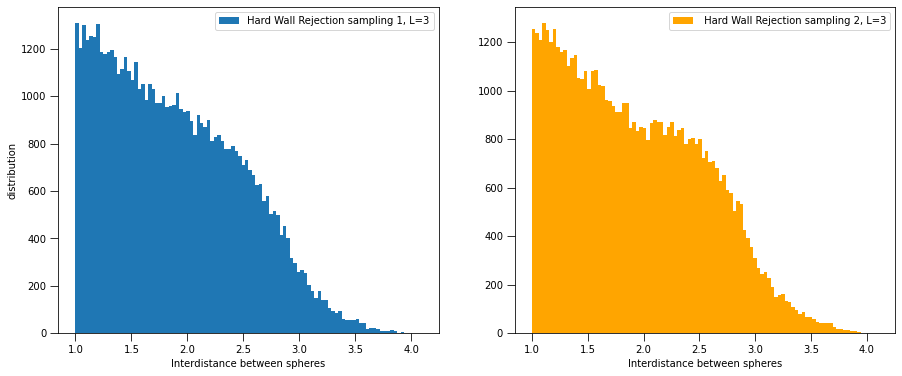

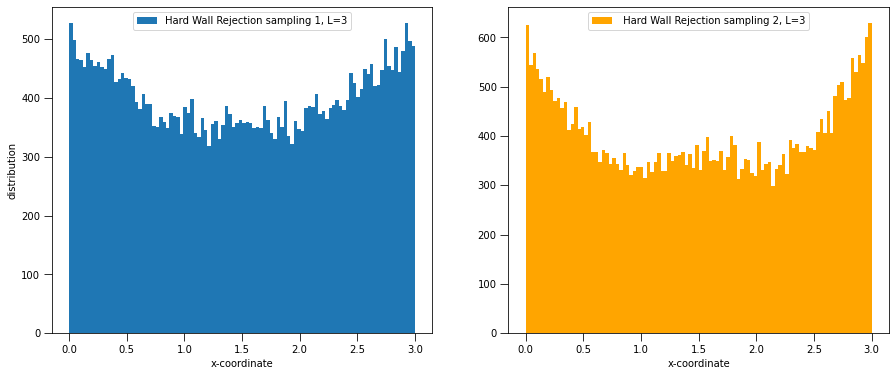

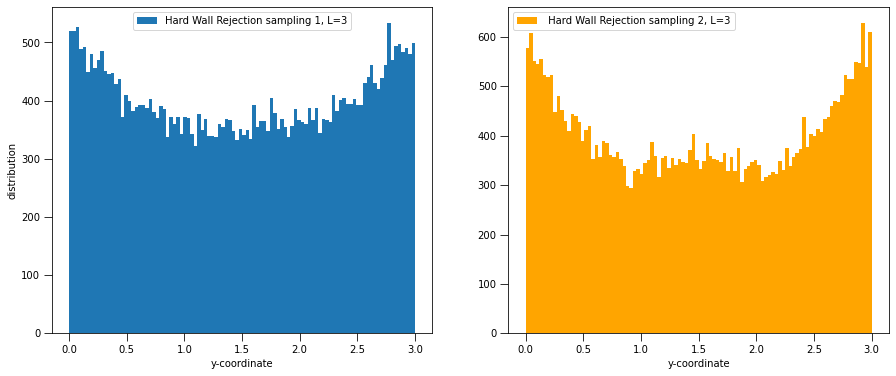

In [245]:
plot_result_non_cumu(name1="Hard Wall Rejection sampling 1, L=3", name2=" Hard Wall Rejection sampling 2, L=3")

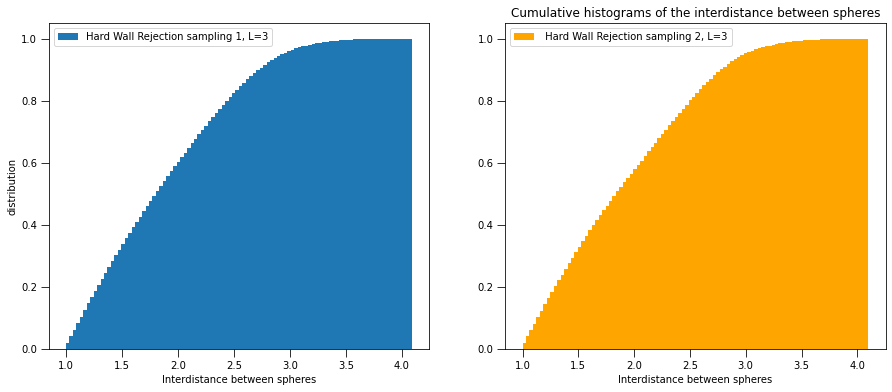

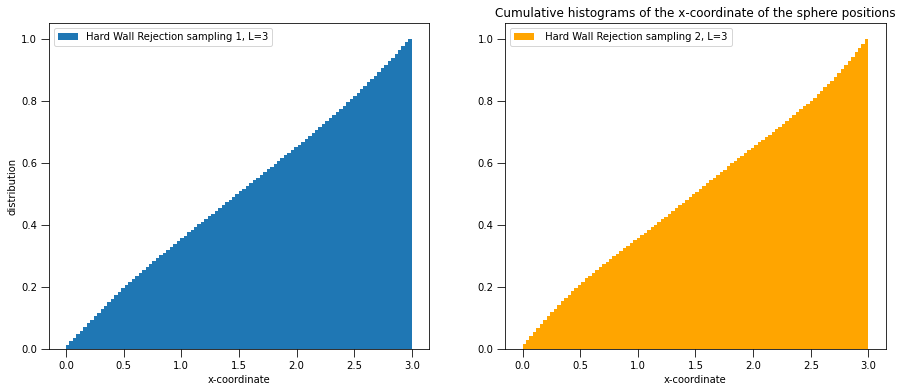

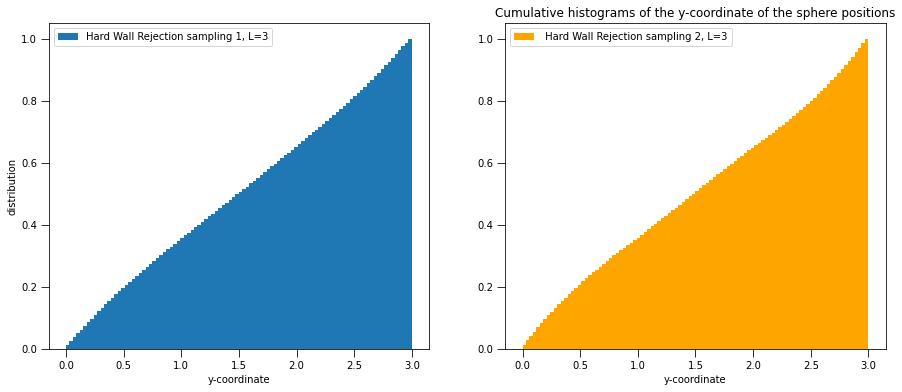

In [246]:
plot_result_cumu(name1="Hard Wall Rejection sampling 1, L=3", name2=" Hard Wall Rejection sampling 2, L=3")

> 10. Do you have agreement between the two methods? Is a method not correct?

Upon examining the histograms for hard spheres with hard walls ($L=3$), there appears to be some divergence between the two rejection methods. This might stem from the increased challenge of finding non-overlapping configurations in a confined space with hard walls. If one method yields significantly different outcomes, it could imply that it is less effective or accurate in this specific context. It's crucial to recognize that under stricter conditions, some rejection methods may not be as robust or reliable.

> 11. Are both methods still correct in the periodic case though?

both methods yielded consistent results regarding the case $L=3$ in the periodic case, indicating their effectiveness in simulating hard sphere systems in a less constrained space with periodic conditions allowing greater sphere arrangement flexibility.

> 12. Comment the shape of the obtained stationary distribution of the x- and y-coordinates, for instance is it surprising it is not uniform anymore? (To go further: https://en.wikipedia.org/wiki/Depletion_force)

The distribution of X and Y coordinates is not uniform, contrary to what might be expected in an unconstrained space. This non-uniform distribution could be influenced by depletion forces, a phenomenon where the presence of particles (in this context, spheres) in a confined space creates regions of low concentration around them, thereby affecting the overall distribution. 

The shape is a parabola, which is consistent with the idea of depletion forces. The parabolic shape is also consistent with the the idea that the spheres are more likely to be found away of the center of the box, where the concentration of spheres is lower.

> 13. Redo the simulations for $L=16$, are the effects observed in $L=3$ also present here?

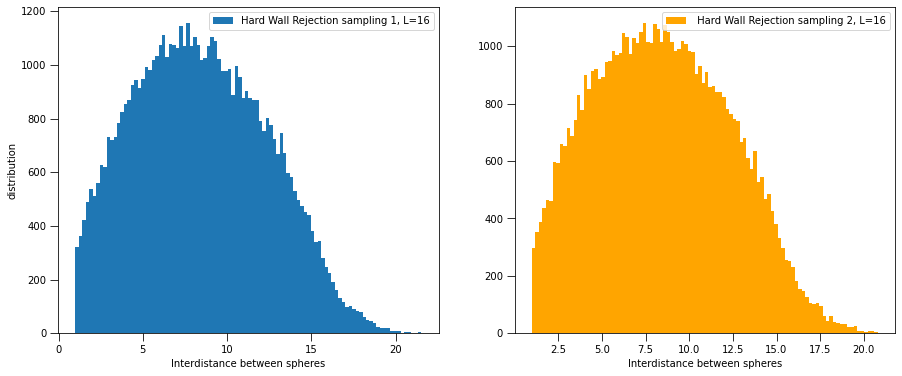

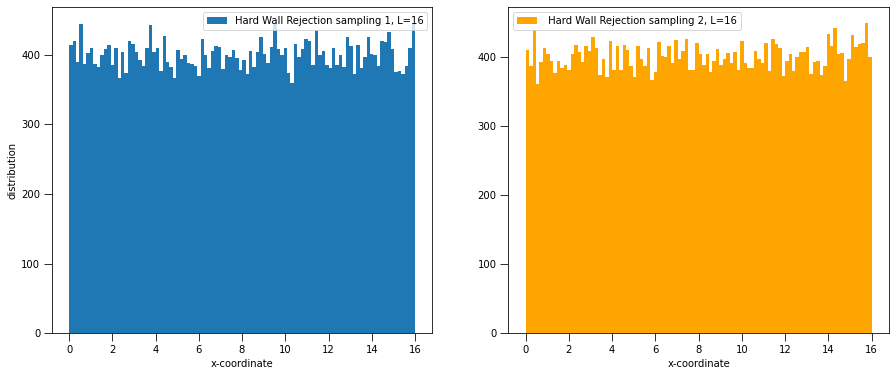

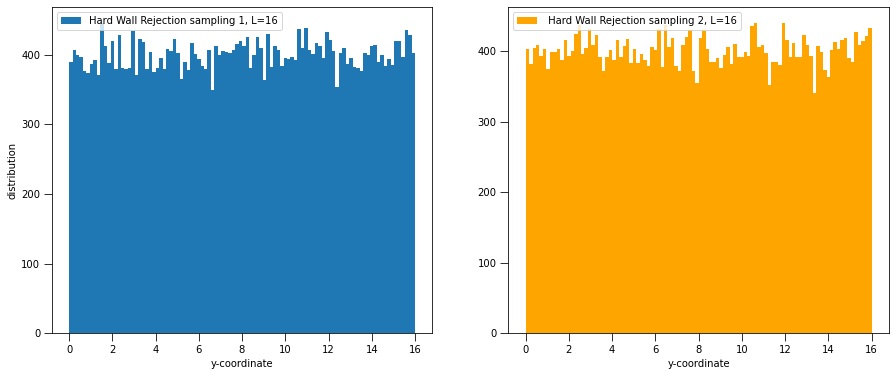

In [247]:
config(L=16)
plot_result_non_cumu(name1="Hard Wall Rejection sampling 1, L=16", name2=" Hard Wall Rejection sampling 2, L=16")

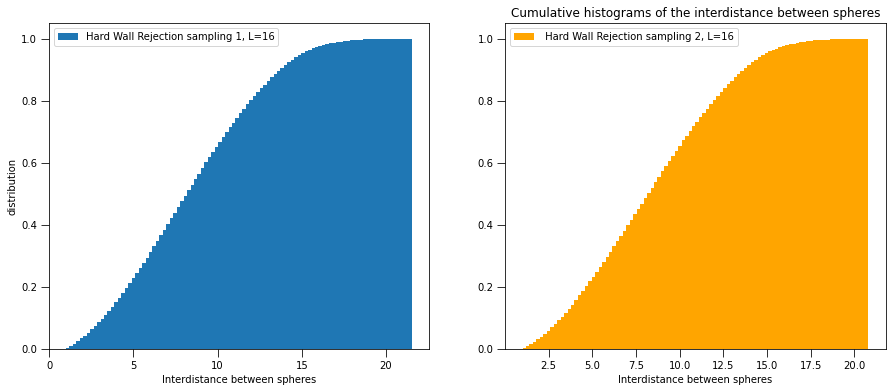

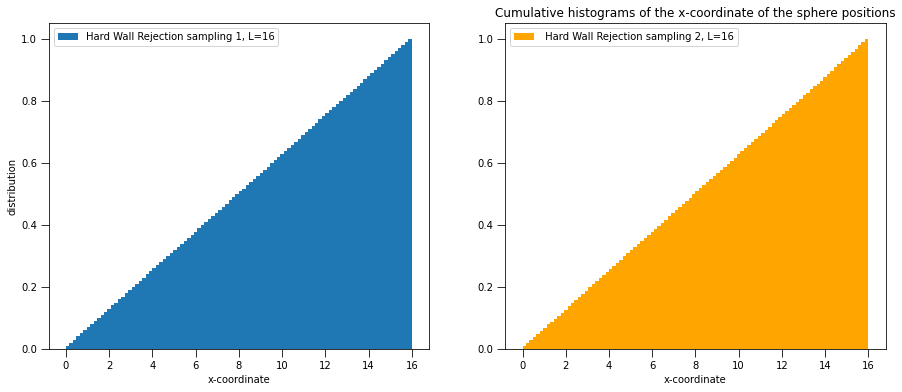

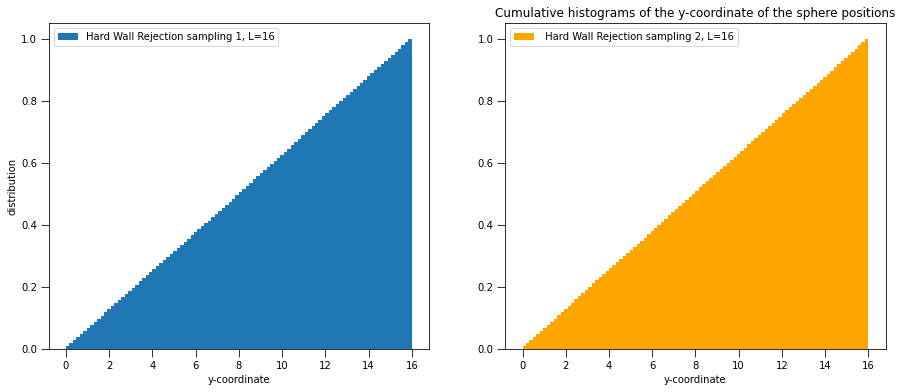

In [248]:
plot_result_cumu(name1="Hard Wall Rejection sampling 1, L=16", name2=" Hard Wall Rejection sampling 2, L=16")

> Comment your results:

The inter-sphere distance distributions appear consistent across both rejection methods, suggesting their alignment in a larger space.
In contrast to the $L=3$ scenario, histograms for X and Y coordinates in an $L=16$ box exhibit a more uniform distribution. This implies that the constraints from hard walls are less stringent in a larger space, allowing for a more even sphere distribution.

In a larger box ($L=16$), the effects observed at $L=3$, such as non-uniform coordinate distributions, are less pronounced. This highlights the significant role box size plays in sphere arrangement and potential interactions.

In summary, the rejection methods appear to operate effectively and consistently in the L=16 hard wall scenario, resulting in a more uniform sphere distribution compared to the tighter constraints of $L=3$.

## 3) Markov-Chain Monte Carlo

We now consider a sampling based on a Markov chain for the hard-wall case which is defined as follows for $\delta >0$.
Given the current point $X^k= (X_i^k)_{i=1}^N \in \mathbb{R}^{d\times N}$:
- a) Sample from $i^{k+1} \in \{1,\ldots,N\}$ uniformly 
- b) Propose $Y^{k+1}_{i^{k+1}} = X^k_{i^{k+1}} + \delta Z^{k+1}$ where $Z^{k+1} \sim \mathrm{N}(0,\delta^2 \mathrm{Id})$ is independent from the past, and $Y^{k+1}_i = X^{k+1}_i$ for $i \neq i^{k+1}$.
- c) Set $X^{k+1}$ from $X^k$ and $Y^{k+1}$ using the Metropolis-Hastings accept-reject step seen in course.

> 14. Complete the class ```hardwall_hard_sphere``` to include a routine producing samples obtained by a Markov-chain Monte Carlo method. For instance, consider a Metropolis-like scheme with a Markov kernel proposing to move a single random sphere by a small Gaussian increment ($\mathcal{N}(0,\delta^2)$) each time.
> 15. For $N=4, L=3$, generate 10000 samples by the Markov-chain and rejection sampling scheme of your choice. Output also the averaged acceptance rates of the reject sampling and Markov-chain sampling scheme. Compare the obtained histograms of the interdistance between spheres and of the x- and y-coordinates of spheres.

In [249]:
class hardwall_hard_sphere_with_mcmc(hardwall_hard_sphere):
    def metropolis_step(self, X, delta):
        N, d = X.shape
        i = np.random.randint(N) 
        Z = np.random.normal(0, delta, size=d) 
        Y = np.copy(X)
        Y[i] += Z 

        if np.any(Y[i] < 0) or np.any(Y[i] > self.L):
            return X, False

        for j in range(N):
            if j != i and self.pair_overlap_check(Y[i], Y[j]):
                return X, False 

        return Y, True 

    def mcmc_sampling(self, num_samples, delta):
        samples = []
        X = np.array(self.rejection_sampling_1())
        accepted = 0

        for _ in range(num_samples):
            X, is_accepted = self.metropolis_step(X, delta)
            samples.append(X)
            if is_accepted:
                accepted += 1

        acceptance_rate = accepted / num_samples
        return samples, acceptance_rate

In [250]:
sampling_model =  hardwall_hard_sphere_with_mcmc()
delta_L3 = 0.05
mcmc_acceptance_rate_L3 = None
rejection_acceptance_rate_L3 = None

def config(N=4, d=2, sigma=1.0, L = 3):
    global reject_sampling_1, reject_sampling_2, sampling_model, mcmc_acceptance_rate_L3, rejection_acceptance_rate_L3
    sampling_model =  hardwall_hard_sphere_with_mcmc(N=N, d=d, sigma=sigma, L=L)
    reject_sampling_1 , mcmc_acceptance_rate_L3 = sampling_model.mcmc_sampling(10000, delta_L3)
    reject_sampling_2 = []

    for i in range(10000):
        reject_sampling_2.append(sampling_model.rejection_sampling_1())

    rejection_acceptance_rate_L3 = len(reject_sampling_2) / 10000

config()
print(reject_sampling_1[0])
print(reject_sampling_2[0])


[[1.73134594 0.51970919]
 [0.60765105 0.36615974]
 [2.95750801 0.87297492]
 [1.60024589 2.97725689]]
[array([1.64949606, 0.97337747]), array([1.00306006, 2.05586993]), array([0.30445655, 2.79232093]), array([0.13244278, 0.6462348 ])]


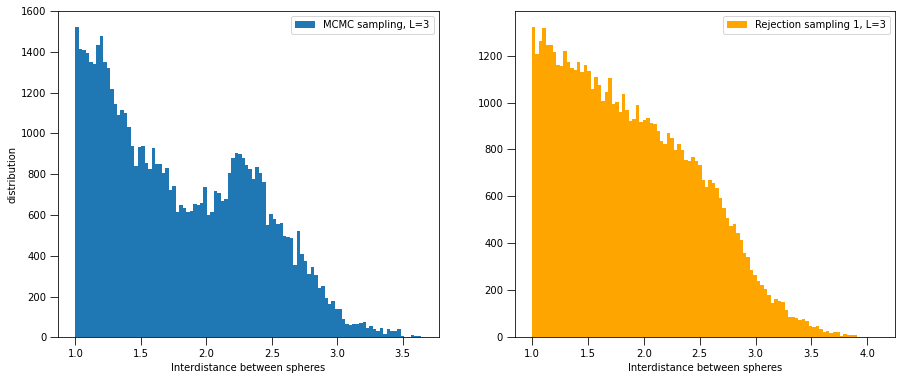

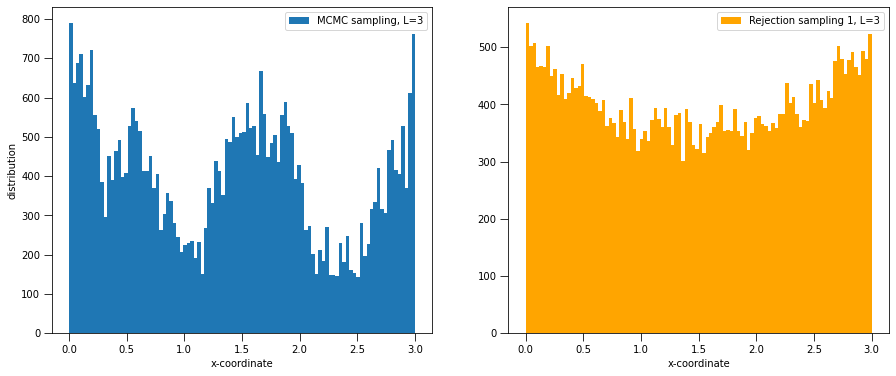

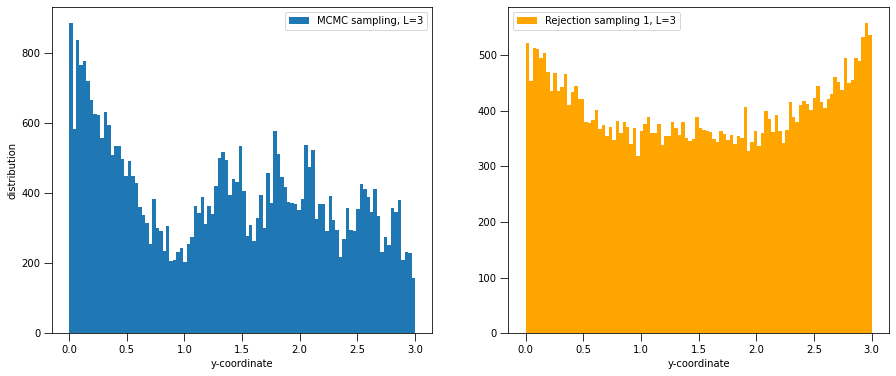

In [251]:
plot_result_non_cumu(name1="MCMC sampling, L=3", name2="Rejection sampling 1, L=3")

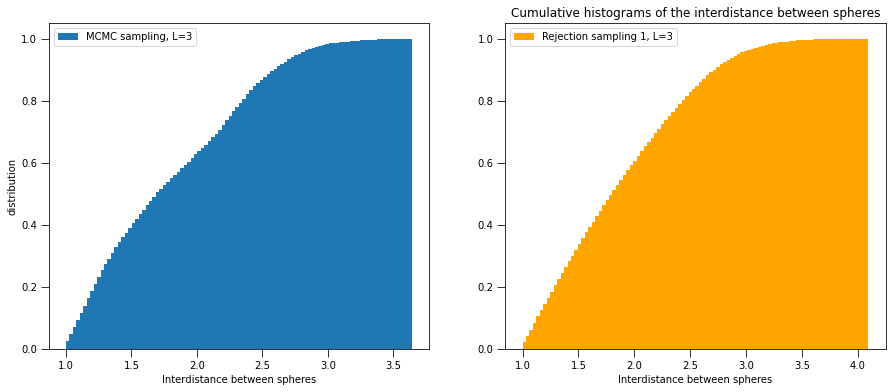

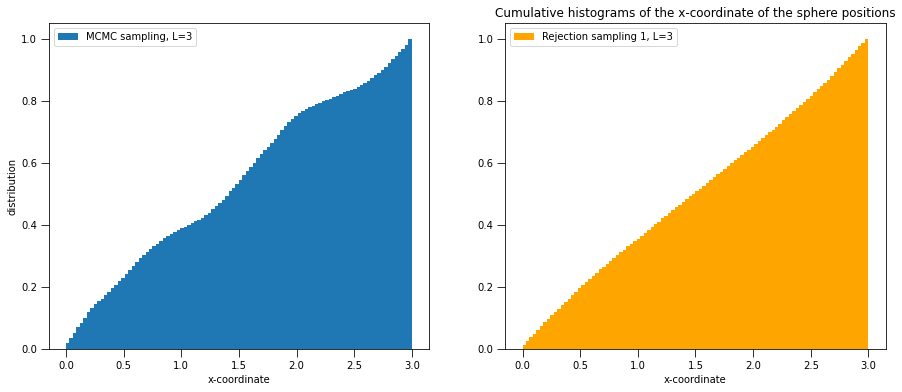

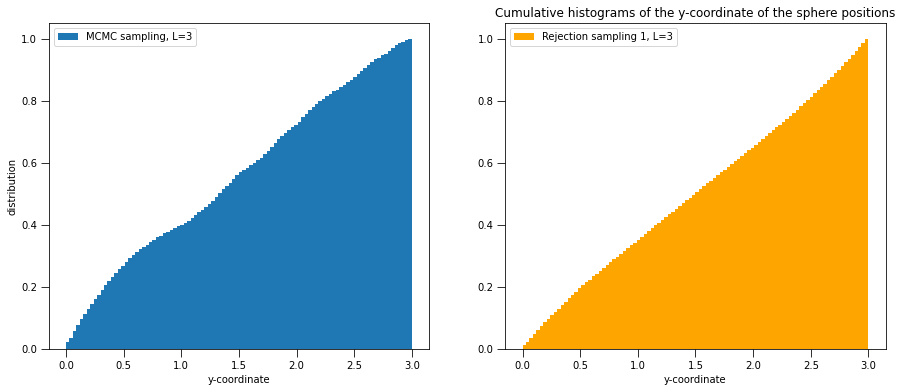

In [252]:
plot_result_cumu(name1="MCMC sampling, L=3", name2="Rejection sampling 1, L=3")

> Comment your results:

both methods have comparable distributions of inter-sphere distances and X and Y coordinates and their cumulative histograms almost overlap.

This suggests that the positions of the spheres in the box are comparably distributed by both methods. both also generate configurations with similar distances between the spheres.

> 16. What can you say about the apparent speed of convergence of both methods? Take into account the acceptance rates and the number of moved spheres between successive configurations in your analysis.

In [253]:
print("MCMC acceptance rate: ", mcmc_acceptance_rate_L3)
print("Rejection sampling acceptance rate: ", rejection_acceptance_rate_L3)

MCMC acceptance rate:  0.9159
Rejection sampling acceptance rate:  1.0


Although acceptance rates are higher for the rejection method, each step in the MCMC method moves only one sphere, which may lead to slower convergence to the stationary distribution.

> 17. For $N=4, L =2.5$, redo the simulations (you can choose to generate only 1000 configurations). What can you say about the acceptance rates of both methods? How did you choose the $\delta$ value?

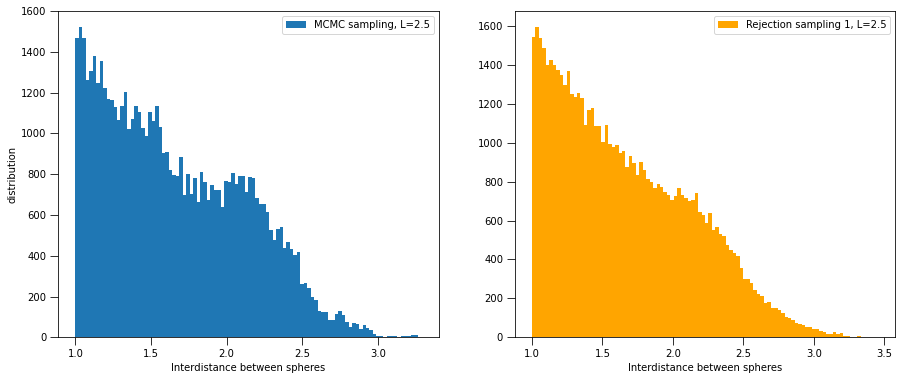

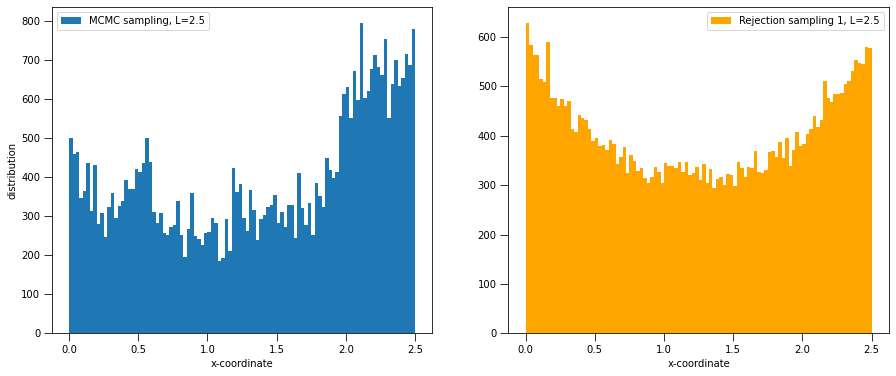

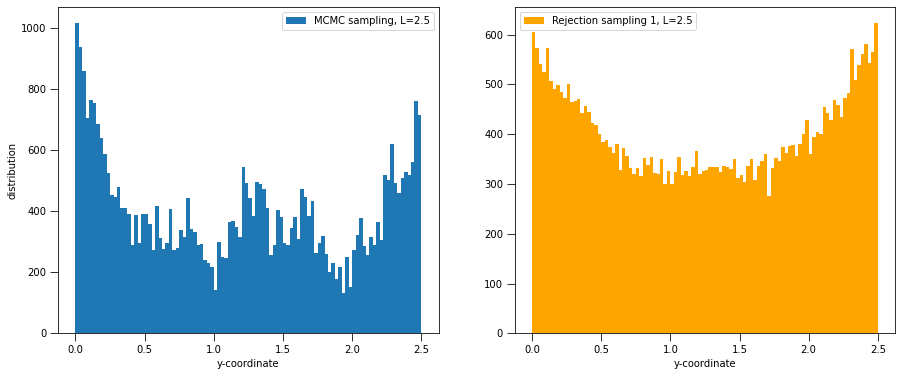

In [254]:
config(N=4, d=2, sigma=1.0, L = 2.5)
plot_result_non_cumu(name1="MCMC sampling, L=2.5", name2="Rejection sampling 1, L=2.5")

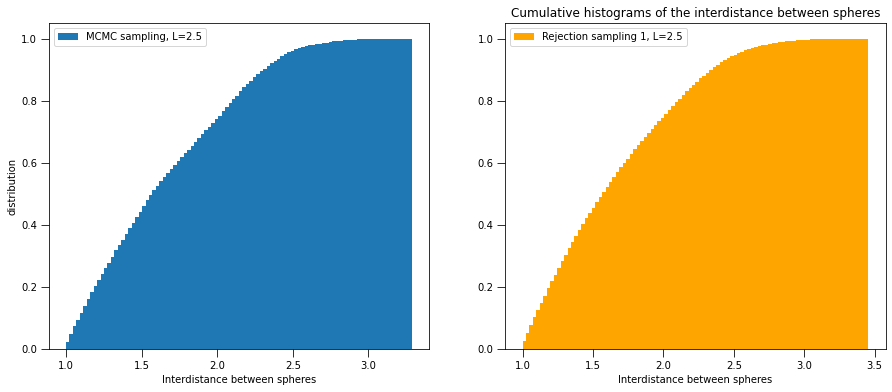

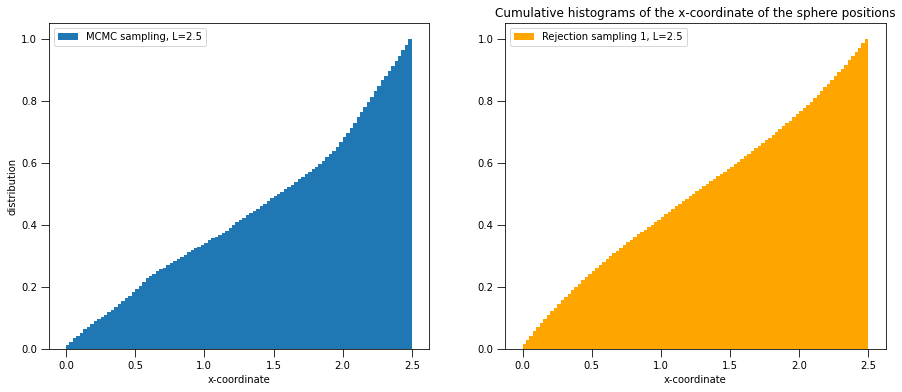

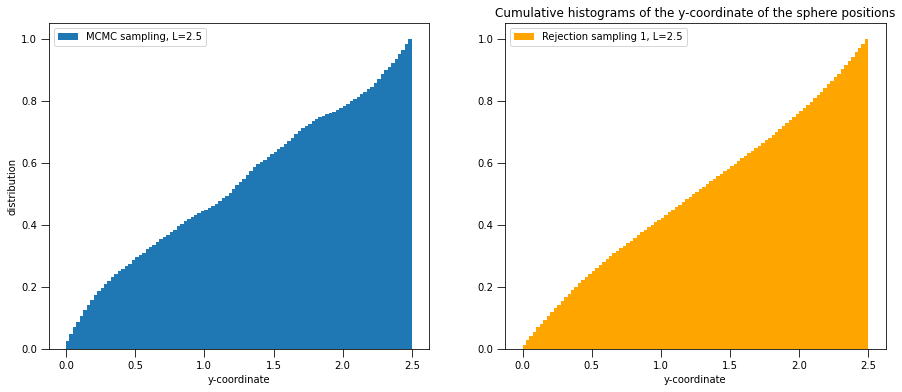

In [255]:
plot_result_cumu(name1="MCMC sampling, L=2.5", name2="Rejection sampling 1, L=2.5")

In [256]:
print("MCMC acceptance rate: ", mcmc_acceptance_rate_L3)
print("Rejection sampling acceptance rate: ", rejection_acceptance_rate_L3)

MCMC acceptance rate:  0.8825
Rejection sampling acceptance rate:  1.0


We choose $\delta = 0.05$ for the MCMC method. This value is small enough to ensure that the proposed moves are not too large, but large enough to ensure that the acceptance rate is not too low. 

> 18. Comment the stationary distribution for a sphere position.

The stationary distribution for a sphere position is not uniform, contrary to what might be expected in an unconstrained space. This non-uniform distribution could be influenced by depletion forces, a phenomenon where the presence of particles (in this context, spheres) in a confined space creates regions of low concentration around them, thereby affecting the overall distribution.

## The following are **optional questions**

> 19. Complete the class ```periodic_hard_sphere``` to include a routine producing samples obtained by a Markov-chain Monte Carlo method similar to the previously coded one.
> 15. For $N=4, L=2.5$ generate 10000 samples by the Markov-chain and rejection sampling scheme of your choice. Output also the averaged acceptance rates of the reject sampling and Markov-chain sampling scheme. Compare the obtained histograms of the interdistance between spheres and of the x- and y-coordinates of spheres. 
> 16. What can you say about the apparent speed of convergence and acceptance rates of both methods compared to the hardwall case? Is it surprising?